In [71]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import pickle
from ggplot import *

RND_STATE = 51834
%matplotlib inline
sns.set_style("whitegrid")

## 1. Loading data

### 1.1 Data load from file

In [72]:
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)

In [73]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


### 1.1 Data exploration

| Variable Name | Description | Type |
| :- | :- | :- |
| SeriousDlqin2yrs | Person experienced 90 days past due delinquency or worse | Y/N |
| RevolvingUtilizationOfUnsecuredLines | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits | percentage |
| age | Age of borrower in years | integer |
| NumberOfTime30-59DaysPastDueNotWorse | Number of times borrower has been 30-59 days past due but no worse in the last 2 years. | integer |
| DebtRatio | Monthly debt payments, alimony,living costs divided by monthy gross income | percentage |
| MonthlyIncome | Monthly income | real |
| NumberOfOpenCreditLinesAndLoans | Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards) | integer |
| NumberOfTimes90DaysLate | Number of times borrower has been 90 days or more past due. | integer |
| NumberRealEstateLoansOrLines | Number of mortgage and real estate loans including home equity lines of credit | integer |
| NumberOfTime60-89DaysPastDueNotWorse | Number of times borrower has been 60-89 days past due but no worse in the last 2 years. | integer |
| NumberOfDependents | Number of dependents in family excluding themselves (spouse, children etc.) | integer |






### 1.2 Checking if classes are imbalanced

In [74]:
def plotClassBalance(classesData):
    ax = sns.countplot(x = classesData)
    ax.set_title('Dataset class balance check')
    ax.set_xlabel('Person experienced 90 days past due delinquency or worse ')
    ax.set_ylabel('Count')
    plt.show()

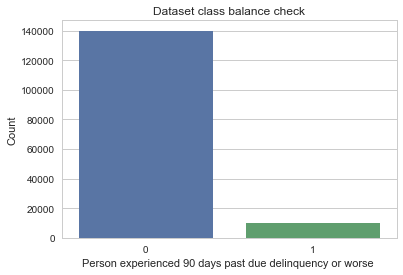

In [75]:
plotClassBalance(data.SeriousDlqin2yrs)

### 1.3 Checking for NAN values

In [76]:
def checkDataFrameNANs(df):
    print('Number of nans by property:')
    print(df.isnull().sum())

In [77]:
checkDataFrameNANs(data)

Number of nans by property:
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


## 2. Data preprocessing

### 2.1 Working with NANs

#### 2.1.1 Working with NumberOfDependents parameter 

Рассматриваемый датасет содержит пропуски в параметре NumberOfDependents. Пропусков достаточно немного, и, чтобы не удалять значения, заменим пропуски в данных медианными значениями.

In [78]:
data['NumberOfDependents'].fillna(data['NumberOfDependents'].median(), inplace = True)

#### 2.1.2 Working with MonthlyIncome parameter 

В используемом датасете очень много пустых значений параметра MonthlyIncome. 
Построим линейную регрессию для восстановления значений параметра.

In [79]:
non_null_data_monInc = data[data.MonthlyIncome.isnull() == False]
null_monInc = data[data.MonthlyIncome.isnull() == True]

monInc_y_train = non_null_data_monInc.MonthlyIncome
monInc_X_train = non_null_data_monInc.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis = 1)
null_monInc = null_monInc.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis=1)

monIncLR = LinearRegression(fit_intercept=True, normalize=True).fit(monInc_X_train, monInc_y_train)

С помощью полученной модели предскажем значения параметра для NAN значений 

In [80]:
monInc_y_pred = monIncLR.predict(null_monInc)
monInc_y_pred[monInc_y_pred < 0] = 0
null_monInc['MonthlyIncome'] = monInc_y_pred

In [81]:
monNew = []
for index in data.index:
    if data.MonthlyIncome[index].is_integer() == True:
        monNew.append(data.MonthlyIncome[index])
    else:
        monNew.append(null_monInc.MonthlyIncome[index])
data.MonthlyIncome = monNew

#### 2.1.3 Cheking for NANs again

In [82]:
print('Number of nans by property:')
checkDataFrameNANs(data)

Number of nans by property:
Number of nans by property:
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


### 2.2 Train test split

In [83]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs

In [84]:
X_train_imb, X_test, y_train_imb, y_test = train_test_split(X, y, test_size = 0.3, random_state = RND_STATE)

### 2.3 Oversampling minor class

Train subset balance before oversampling

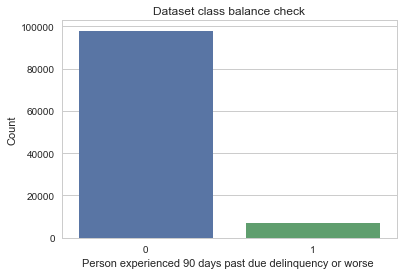

In [85]:
plotClassBalance(y_train_imb)

In [86]:
sm = SMOTE(random_state = RND_STATE)
X_res, y_res = sm.fit_sample(X_train_imb, y_train_imb)

And after oversampling

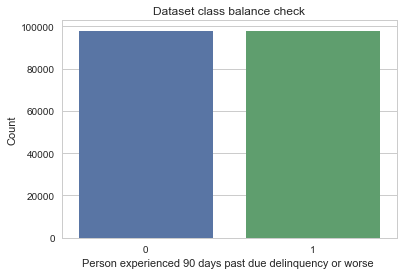

In [87]:
plotClassBalance(y_res)

In [88]:
X_train = X_res.copy()
y_train = y_res.copy()

## 3. Data prediction

### 3.1 Building models

In [19]:
folds = StratifiedKFold(n_splits = 10, random_state = RND_STATE, shuffle = False)

In [46]:
def fit_model(model, params, folds, Xtrain, ytrain):
    cv = GridSearchCV(model, param_grid = params, scoring = 'roc_auc', cv = folds, n_jobs = -1, verbose = 1)
    cv.fit(Xtrain, ytrain)
    print('CV best score:', cv.best_score_)
    return cv.best_estimator_

In [66]:
def check_model(model, Xtest, ytest, plot_color):
    predicted = model.predict(Xtest)
    predicted_proba = model.predict_proba(Xtest)[:, 1]
    roc_auc = roc_auc_score(ytest, predicted_proba)
    
    print("ROC AUC score:", roc_auc)
    
    fpr, tpr, thresholds = roc_curve(ytest, predicted_proba)
    df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
    print(ggplot(df, aes(x = 'fpr', y ='tpr')) +\
        geom_line(color=plot_color, size = 2, alpha = 0.5) +\
        geom_abline(linetype = 'dashed') +\
        xlab("false positive rate ($fpr$)") + ylab("true positive rate ($tpr$)") + ggtitle("ROC curve"))

In [22]:
def print_importances(model):
    importances = model.feature_importances_
    print(str("Топ - 5 важнейших признаков:") + '\n')
    val_zip = zip(X.columns, importances) 
    for a, b, in sorted(val_zip, key = lambda zp_gb: zp_gb[1], reverse = True)[:5]:
        print("{0}: {1}".format(a, b))

In [23]:
def print_importances_coef(model):
    importances = model.coef_.flatten()
    print(str("Топ - 5 важнейших признаков:") + '\n')
    val_zip = zip(X.columns, importances) 
    for a, b, in sorted(val_zip, key = lambda zp_lr: zp_lr[1], reverse = True)[:5]:
        print("{0}: {1}".format(a, b))

In [24]:
def save_model(model, name):
    with open('data/saved_models/' + name, 'wb') as file:
        pickle.dump(model, file, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
def load_model(name):
    with open('data/saved_models/' + name, 'rb') as file:
        return pickle.load(file)

#### 3.1.1 Gradient Boosting

In [26]:
gb_best = load_model('gb.pickle')

Подбираем параметры для GradientBoostingClassifier

In [ ]:
#создаем объект класса GradientBoostingClassifier() с определенным набором параметров
gb = GradientBoostingClassifier(learning_rate = 0.1, subsample = 0.7,  
                                max_features = 'sqrt', random_state = RND_STATE)
#устанавливаем диапозон параметров для скользящего контроля
gb_params = {'loss': ['deviance', 'exponential'],
             'min_samples_leaf': [2, 3, 4, 5], 
             'n_estimators': [150], 'random_state' : [RND_STATE]}

gb_best = fit_model(gb, gb_params, folds, X_train, y_train)

In [142]:
save_model(gb_best, 'gb.pickle')

ROC AUC score: 0.853971358188


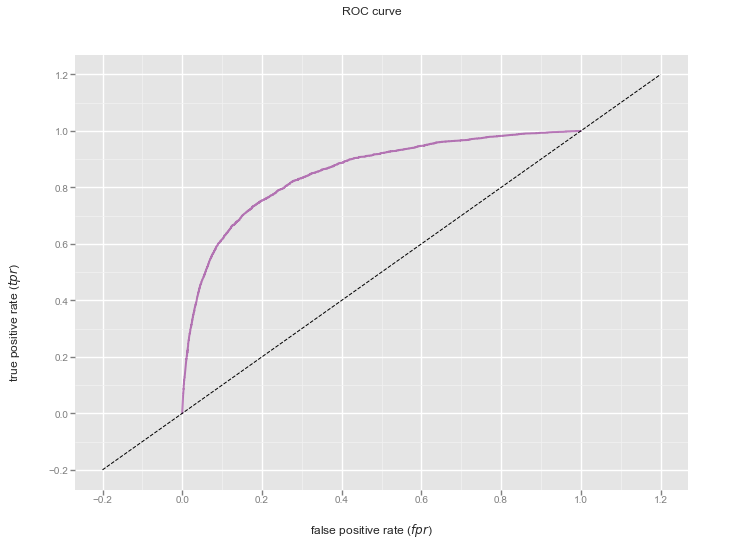

<ggplot: (299503992)>


In [27]:
check_model(gb_best, X_test, y_test, 'purple')

In [28]:
print_importances(gb_best)

Топ - 5 важнейших признаков:

NumberOfDependents: 0.2176126946934697
NumberRealEstateLoansOrLines: 0.2040648349815809
NumberOfTime30-59DaysPastDueNotWorse: 0.17091956664381647
RevolvingUtilizationOfUnsecuredLines: 0.09555064095296614
NumberOfTimes90DaysLate: 0.09551357801255474


#### 3.1.2 Random Forest

In [29]:
rf_best = load_model('rf.pickle')

In [148]:
#количество n_splits было увеличено, чтобы избежать переобучения
folds_rf = StratifiedKFold(n_splits = 25, random_state = RND_STATE) 

Подбираем параметры для RandomForestClassifier

In [24]:
rf_params = {'criterion': ['gini', 'entropy'], 
         'max_features': [1, 5, 10, 'log2', 'auto'],
         'max_depth': [2, 4, 8, 16, 32], 
         'class_weight': ['balanced'], 'random_state' : [RND_STATE]}

rf_best = fit_model(RandomForestClassifier(), rf_params, folds_rf, X_train, y_train)
#предсказание меток класса
rf_cv_prediction = rf_cv.predict(X_test)
#предсказание вероятности принадлежности к одному из классов
rf_cv_prediction_proba = rf_cv.predict_proba(X_test)[:, 1]
#вычисляем значение метрики 
roc_auc_rf = roc_auc_score(y_test, rf_cv_prediction_proba)

Fitting 25 folds for each of 50 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 46.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 86.5min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed: 87.1min finished


In [150]:
save_model(rf_best, 'rf.pickle')

ROC AUC score: 0.800069249985


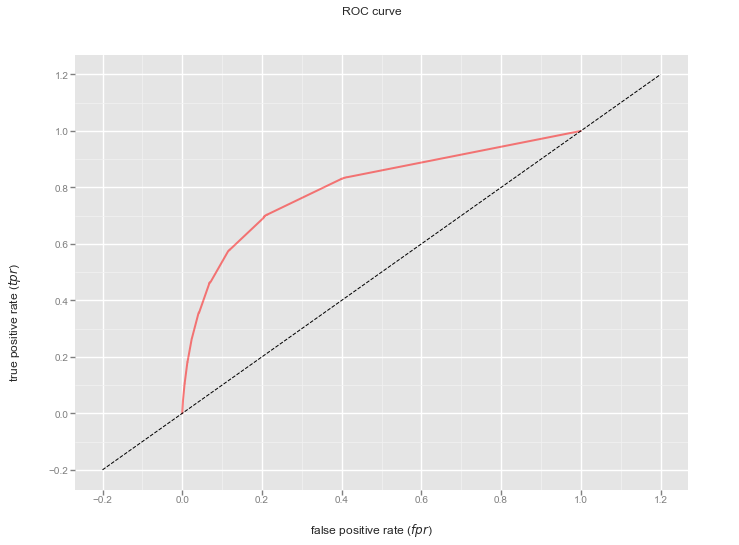

<ggplot: (308431613)>


In [30]:
check_model(rf_best, X_test, y_test, 'red')

In [31]:
print_importances(rf_best)

Топ - 5 важнейших признаков:

RevolvingUtilizationOfUnsecuredLines: 0.17455612509785937
NumberOfTimes90DaysLate: 0.15245190978654402
NumberOfTime30-59DaysPastDueNotWorse: 0.14697929024345238
NumberOfTime60-89DaysPastDueNotWorse: 0.10731836441566904
NumberRealEstateLoansOrLines: 0.08743540967243424


#### 3.1.3 Logistic Regression

In [32]:
lr_best = load_model('lr.pickle')

Подбираем параметры для LogisticRegression

In [30]:
#создаем объект класса LogisticRegression() с определенным набором параметров
lr = LogisticRegression(class_weight = 'balanced', random_state = RND_STATE)

#устанавливаем диапозон параметров для скользящего контроля
lr_params = {'penalty': ['l1', 'l2'], 
             'C': [0.5, 0.8, 1.0], 'random_state' : [RND_STATE]}

lr_best = fit_model(lr, lr_params, folds, X_train, y_train)

Fitting 25 folds for each of 6 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.5min finished


In [163]:
save_model(lr_best, 'lr.pickle')

ROC AUC score: 0.79943139677


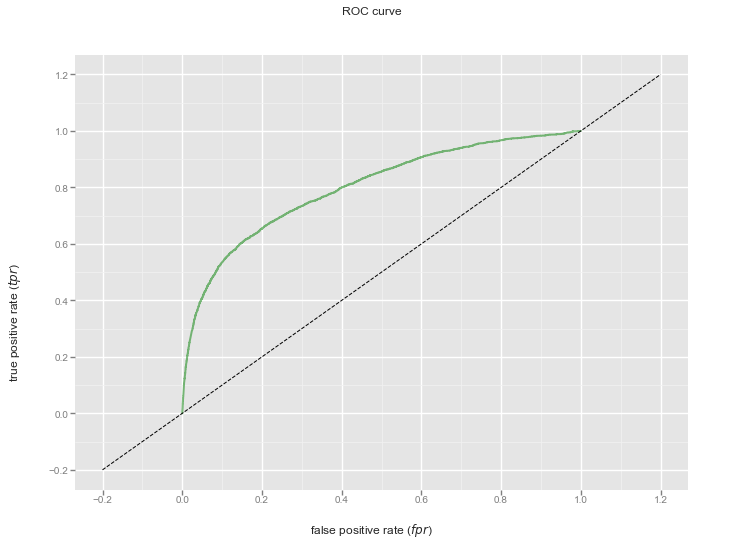

<ggplot: (308426728)>


In [33]:
check_model(lr_best, X_test, y_test, 'green')

In [34]:
print_importances_coef(lr_best)

Топ - 5 важнейших признаков:

NumberOfTimes90DaysLate: 0.7235590625922033
NumberOfTime30-59DaysPastDueNotWorse: 0.6687871101117892
NumberRealEstateLoansOrLines: 0.09328844307009083
NumberOfDependents: 0.08751915098800242
NumberOfTime60-89DaysPastDueNotWorse: 0.07774494259863379


#### 3.1.4 Adaboost classifier

In [35]:
ada_best = load_model('ada.pickle')

Подбираем параметры для AdaBoostClassifier

In [36]:
#устанавливаем диапозон параметров для скользящего контроля
ab_params = {'base_estimator__criterion' : ["gini", "entropy"],
          'base_estimator__splitter' :   ["best", "random"],
          'n_estimators': [1, 2]}

dtc = DecisionTreeClassifier(random_state = RND_STATE, max_features = "auto", 
                             class_weight = "balanced", max_depth = None)

ab = AdaBoostClassifier(base_estimator = dtc)

ada_best = fit_model(ab, ab_params, folds, X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   45.0s finished


In [171]:
save_model(ada_best, 'ada.pickle')

ROC AUC score: 0.692117573273


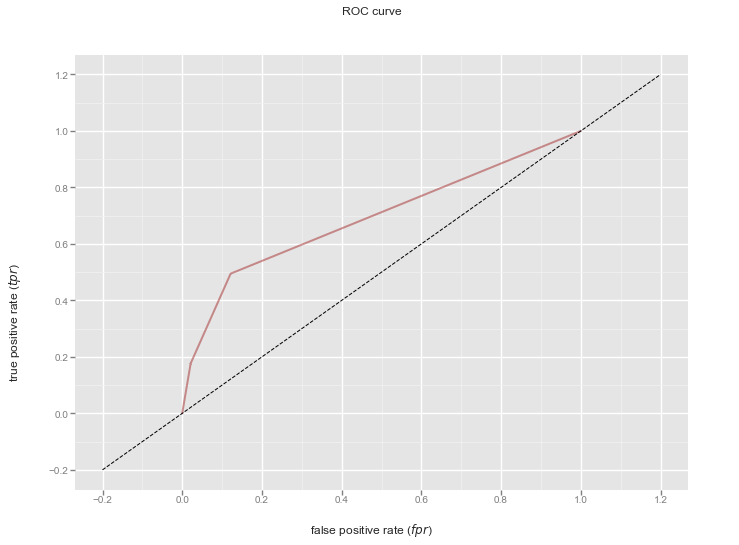

<ggplot: (308020137)>


In [36]:
check_model(ada_best, X_test, y_test, 'brown')

In [37]:
print_importances(ada_best)

Топ - 5 важнейших признаков:

NumberOfTime30-59DaysPastDueNotWorse: 0.23753960427544216
NumberRealEstateLoansOrLines: 0.12383757082943242
NumberOfTime60-89DaysPastDueNotWorse: 0.10189610843940572
NumberOfTimes90DaysLate: 0.10167546496313908
NumberOfOpenCreditLinesAndLoans: 0.0946181469855846


#### 3.1.5 Decision Trees classifier

In [38]:
dt_best = load_model('dt.pickle')

Подбираем параметры для DecisionTreeClassifier

In [41]:
#устанавливаем диапозон параметров для скользящего контроля
dt_params = {'criterion': ['gini', 'entropy'], 
         'max_features': [1, 5, 10, 'log2', 'auto'],
         'max_depth': [2, 4, 8, 16, 32], 
         'random_state' : [RND_STATE]}

dt = DecisionTreeClassifier(random_state = RND_STATE, class_weight ='balanced')

dt_best = fit_model(dt, dt_params, folds, X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  3.1min finished


In [177]:
save_model(dt_best, 'dt.pickle')

ROC AUC score: 0.83413447118


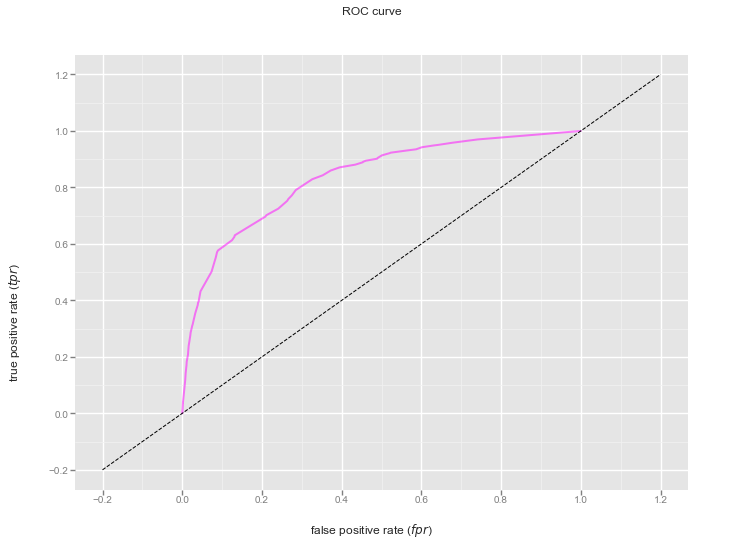

<ggplot: (308443775)>


In [39]:
check_model(dt_best, X_test, y_test, 'magenta')

In [40]:
print_importances(dt_best)

Топ - 5 важнейших признаков:

NumberOfTime30-59DaysPastDueNotWorse: 0.5608777223371707
NumberOfTimes90DaysLate: 0.1998254800701682
NumberOfDependents: 0.08156742117443229
RevolvingUtilizationOfUnsecuredLines: 0.07369460117153466
NumberOfTime60-89DaysPastDueNotWorse: 0.06047178044068172


#### 3.1.6 KNeighborsClassifier

In [41]:
knn_best = load_model('knn.pickle')

In [46]:
#устанавливаем диапозон параметров для скользящего контроля
knn_params = {'n_neighbors': np.arange(1, 31, 2),
              'metric': ['euclidean', 'cityblock']}

knn = KNeighborsClassifier()

knn_best = fit_model(knn, knn_params, folds, X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 81.1min finished


In [185]:
save_model(knn_best, 'knn.pickle')

ROC AUC score: 0.609467062617


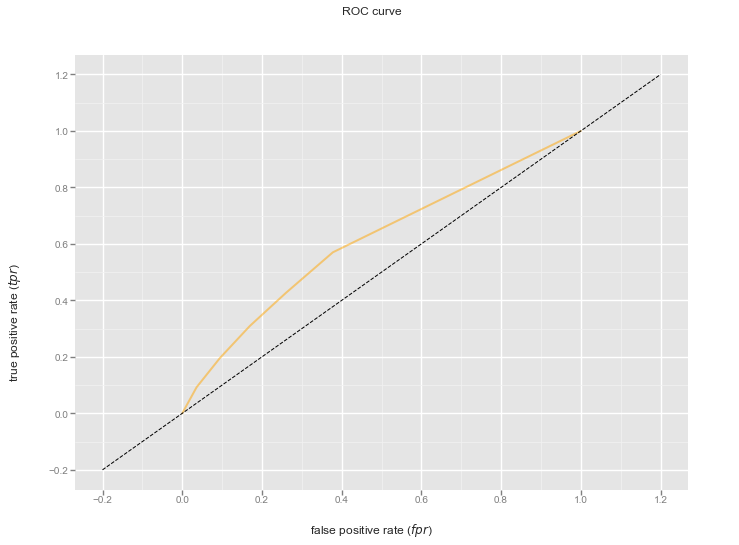

<ggplot: (298664396)>


In [42]:
check_model(knn_best, X_test, y_test, 'orange')

#### 3.1.7 SVC

In [119]:
svc_best = load_model('svc.pickle')

Подбираем параметры для SVC

In [110]:
#создаем объект класса SVC()
folds_svc = StratifiedKFold(n_splits = 2, random_state = RND_STATE, shuffle = False)
svc = SVC(random_state = RND_STATE, cache_size=2048, class_weight='balanced', decision_function_shape='ovr', probability=True)

#устанавливаем диапозон параметров для скользящего контроля
svc_params = {'kernel': ['rbf', 'sigmoid'], 'C' : [0.5, 1, 5, 10]}
svc_best = fit_model(svc, svc_params, folds_svc, X_train_imb[:10000], y_train_imb[:10000])

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   40.8s finished


CV best score: 0.5310812497


In [111]:
save_model(svc_best, 'svc.pickle')

ROC AUC score: 0.544564905459


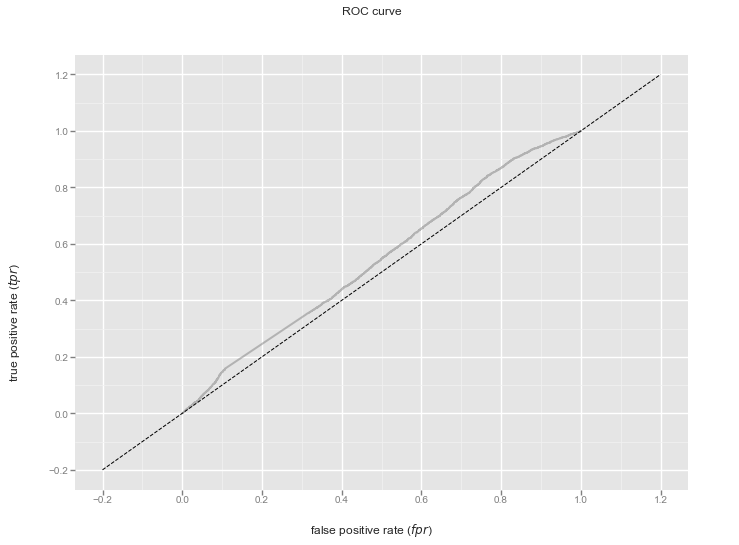

<ggplot: (-9223372036546421118)>


In [112]:
check_model(svc_best, X_test, y_test, 'grey')

#### 3.1.8 XGBoost

In [ ]:
xgb_best = load_model('xgb.pickle')

Подбираем параметры для XGBClassifier

In [52]:
#создаем объект класса XGBClassifier() с определенным набором параметров
xgb = XGBClassifier(learning_rate = 0.1, n_estimators = 150, 
                            max_delta_step = 1.5, min_child_weight = 1, 
                            gamma = 0, colsample_bytree = 0.5, subsample = 0.78,
                            objective= 'binary:logistic', scale_pos_weight = 1, seed = RND_STATE)
#устанавливаем диапозон параметров для скользящего контроля
xgb_params = {'max_depth': [3, 4, 5, 6, 8], 
              'colsample_bytree': [0.5, 0.8]}

xgb_best = fit_model(xgb, xgb_params, folds, X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 27.1min finished


CV best score: 0.98464592689


In [53]:
save_model(xgb_best, 'xgb.pickle')

ROC AUC score: 0.85749331954


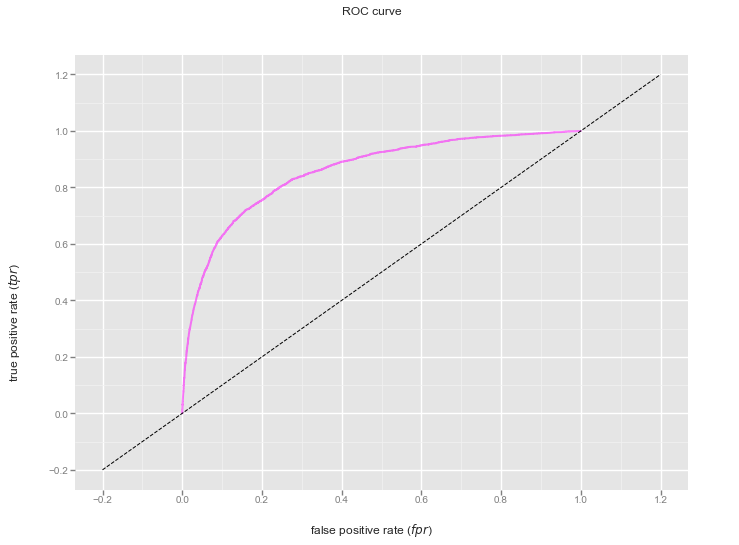

<ggplot: (308367624)>


In [67]:
check_model(xgb_best, X_test.values, y_test, 'magenta')

In [68]:
print_importances(xgb_best)

Топ - 5 важнейших признаков:

NumberOfOpenCreditLinesAndLoans: 0.1341852992773056
age: 0.11501597613096237
NumberRealEstateLoansOrLines: 0.11182108521461487
NumberOfTimes90DaysLate: 0.10891664028167725
NumberOfTime30-59DaysPastDueNotWorse: 0.10165553539991379


#### 3.1.9 MLP

In [128]:
mlp_best = load_model('mlp.pickle')

In [126]:
#создание объекта класса MLPClassifier, устанавливая балансировку классов
mlp = MLPClassifier(random_state = RND_STATE) 
#установление набора параметров
mlp_params = {'activation' : ['identity', 'logistic', 'tanh', 'relu'],
'solver': ['lbfgs', 'sgd', 'adam'],
'hidden_layer_sizes': np.arange(1, 4)}

mlp_best = fit_model(mlp, mlp_params, None, X_train_imb[:10000], y_train_imb[:10000])

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   23.2s finished


CV best score: 0.636921653255


In [127]:
save_model(mlp_best, 'mlp.pickle')

ROC AUC score: 0.637683532317


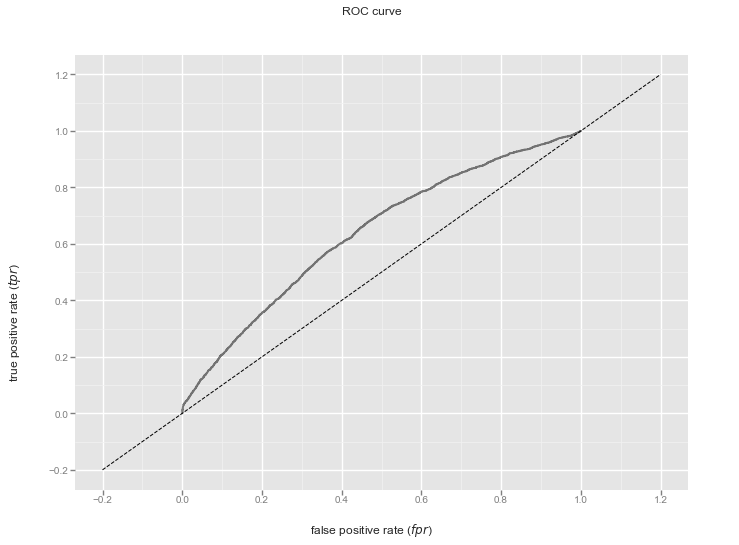

<ggplot: (309208142)>


In [129]:
check_model(mlp_best, X_test, y_test, 'black')

In [130]:
importances_mlp = mlp_best.coefs_[0].flatten() #получение весов признаков
print(str("Топ - 5 важнейших признаков:") + '\n')
mlp_zip = zip(X.columns, importances_mlp) 
for a, b, in sorted(mlp_zip, key = lambda zp_mlp: zp_mlp[1], reverse = True)[:5]:
    print("{0}: {1}".format(a, b))

Топ - 5 важнейших признаков:

NumberOfTime30-59DaysPastDueNotWorse: 0.5512827843669769
NumberRealEstateLoansOrLines: 0.3591193572542884
NumberOfOpenCreditLinesAndLoans: 0.21813598359453712
NumberOfTime60-89DaysPastDueNotWorse: 0.09197650890118805
DebtRatio: -0.00030521718539227444


#### 3.10 Voting clf

In [ ]:
voting_best = load_model('voting.pickle')

In [47]:
clf1 = gb_best
clf2 = rf_best
clf3 = knn_best

voting = VotingClassifier(estimators=[('gb', clf1), ('rf', clf2), ('knn', clf3)])

voting_params = {'voting': ['soft']}

voting_best = fit_model(voting, voting_params, folds, X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.5min finished


CV best score: 0.996522624037


In [48]:
save_model(voting_best, 'voting.pickle')

ROC AUC score: 0.808204309991


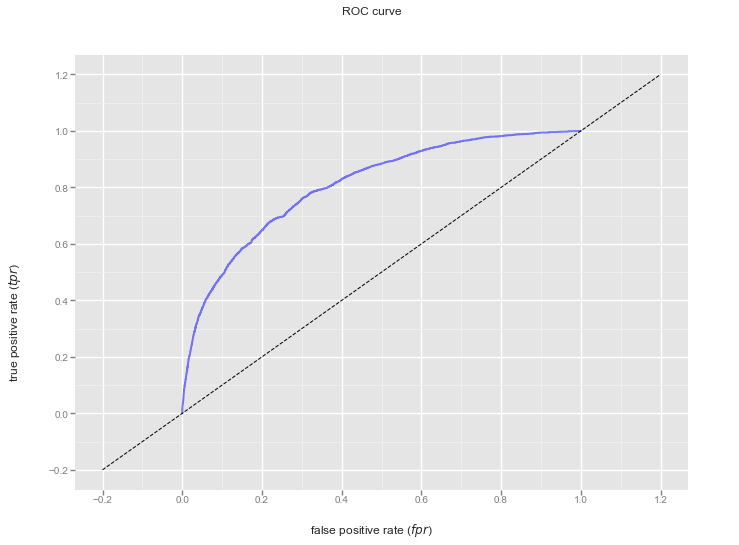

<ggplot: (308026523)>


In [49]:
check_model(voting_best, X_test, y_test, 'blue')

### results

1. ROC AUC score: 0.853971358188 gb
2. ROC AUC score: 0.800069249985 rf
3. ROC AUC score: 0.83413447118 dt
4. ROC AUC score: 0.687102056134 ada
5. ROC AUC score: 0.79943139677 lr
6. ROC AUC score: 0.609480240747 knn
7.
8.
9.
10.